In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0
!pip install pygame

from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2, DQN

TensorFlow 1.x selected.
     |████████████████████████████████| 248 kB 5.3 MB/s 
  Attempting uninstall: stable-baselines
    Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1
     |████████████████████████████████| 11.8 MB 150 kB/s 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
import os
import numpy as np
import sys
import math
import random
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import gym
from gym import spaces
# from gym.envs.classic_control import rendering

import pygame
from pygame.locals import *

from google.colab import files
from google.colab.patches import cv2_imshow
from google.colab import output

# os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.0.1 (SDL 2.0.14, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


# OOP Code

## Piece

In [ ]:
class Piece:
    def __init__(self, *args):
        if len(args) == 0:
            self.value = 0
        elif len(args) == 1:
            self.value = args[0]

    def set_value(self, value):
        self.value = value

    def get_value(self):
        return self.value

    def value_upgrade(self):
        self.value *= 2

    def value_remove(self):
        self.value = 0


## Board

In [ ]:
class Board:
    def __init__(self, rows, cols):
        self.cols = cols
        self.rows = rows

        self.board = []
        for r in range(self.rows):
            self.board.append([])
            for c in range(self.cols):
                self.board[r].append(Piece())

    def get_board_values(self):
        b = []
        for r in range(self.rows):
            b.append([])
            for c in range(self.cols):
                b[r].append(self.board[r][c].get_value())
        return b

    def get_piece(self, row, col):
        return self.board[row][col]

    def put_piece(self, row, col, piece):
        self.board[row][col] = piece

    def put_piece_value(self, row, col, value):
        self.board[row][col].set_value(value)

    def remove_piece(self, row, col):
        self.board[row][col].value_remove()

    def get_empty_pos(self):
        empty_r = []
        empty_c = []

        for r in range(self.rows):
            for c in range(self.cols):
                if self.board[r][c].get_value() == 0:
                    empty_r.append(r)
                    empty_c.append(c)

        return empty_r, empty_c

    def move_piece(self, old_r, old_c, new_r, new_c):

        piece_o = self.get_piece(old_r, old_c)
        piece_d = self.get_piece(new_r, new_c)

        if piece_o.get_value() == 0:
            raise ValueError('Old position ({}, {}) empty!'.format(old_r, old_c))
        if piece_d.get_value() != 0:
            raise ValueError('New position ({}, {}) already ocupied!'.format(new_r, new_c))

        self.put_piece(new_r, new_c, piece_o)
        self.put_piece(old_r, old_c, Piece())

    def merge_pieces(self, row1, col1, row2, col2):
        self.board[row1][col1].value_upgrade()
        self.remove_piece(row2, col2)
        return self.board[row1][col1].get_value()


## BoardController

In [ ]:
class BoardController:
	def __init__(self, rows, cols):
		self.rows = rows
		self.cols = cols
		self.board = Board(self.rows, self.cols)

	def get_rowcols(self):
		return self.rows, self.cols

	def set_board(self, new_board):
		for ind_r, r in enumerate(new_board):
			for ind_c, c in enumerate(r):
				self.board.put_piece(ind_r, ind_c, Piece(c))

	def get_board_values(self):
		return self.board.get_board_values()

	def get_board(self):
		return self.board

	def get_score(self):
		b = self.board.get_board_values()

		sum = 0
		for r in b:
			for c in r:
				sum += c
		return sum

	def get_score_position(self, x, y):
		v = self.board.get_piece(x, y).get_value()
		return v

	def get_max_value(self):
		b = self.board.get_board_values()

		max = 0
		for r in b:
			for c in r:
				if c > max:
					max = c
		return max

	def get_max_value_position(self):
		b = self.board.get_board_values()
		x = 0
		y = 0
		max = 0
		for indr, r in enumerate(b):
			for indc, c in enumerate(r):
				if c > max:
					x = indc
					y = indr
					max = c
		return x, y

	def appear_piece(self):
		empty_r, empty_c = self.board.get_empty_pos()
		random_ind = random.randint(0, len(empty_r)-1)

		random_value = random.randint(1,10)
		if random_value <= 9: # 90% value 2
			random_value = 2
		else: # 10% value 4
			random_value = 4

		# print(empty_r, empty_c, random_ind, random_value)

		self.board.put_piece(empty_r[random_ind], empty_c[random_ind], Piece(random_value))
		return empty_r[random_ind], empty_c[random_ind]

	def reestart_board(self):
		for r in range(self.rows):
			for c in range(self.cols):
				self.board.put_piece(r, c, Piece())

	def check_nomoves(self):
		for r in range(self.rows):
			for c in range(self.cols):
				value = self.board.get_piece(r, c).get_value()
				if value == 0:
					return False

				if r != 0:
					value_up = self.board.get_piece(r-1, c).get_value()
					if value_up == value:
						return False
				if c != 0:
					value_left = self.board.get_piece(r, c-1).get_value()
					if value_left == value:
						return False
		return True

	def check_winner(self):
		b = self.get_board_values()
		for r in b:
			for c in r:
				if c == 2048:
					return True
		return False


	def move_left(self):
		movements = 0
		merged_values = 0
		try:
			for r in range(self.rows):
				merged_row = False
				for c in range(self.cols):
					if c != 0: # ignore the pieces on position 0 that will not move
						if self.board.get_piece(r, c).get_value() != 0:
							# print('-----')
							piece_c = c
							while(self.board.get_piece(r, piece_c-1).get_value() == 0):
								self.board.move_piece(r, piece_c, r, piece_c-1)
								# print('moving ({}, {}) to ({}, {})'.format(r,piece_c, r,piece_c-1))

								movements += 1
								piece_c -= 1
								if piece_c == 0:
									break

							if merged_row == False and piece_c != 0:

								# b_values = self.get_board()
								# print(np.matrix(b_values))

								if self.can_be_merged(r, piece_c-1, r, piece_c):
									# print('merged')
									m_value = self.board.merge_pieces(r, piece_c-1, r, piece_c)
									merged_row = True
									movements += 1
									merged_values += m_value

			return movements, merged_values

		except ValueError as ve:
			print(str(ve))
			return 0

	def move_right(self):
		movements = 0
		merged_values = 0
		try:
			for r in range(self.rows):
				merged_row = False
				for c in range(self.cols-1, -1, -1):
					if c != self.cols-1:
						if self.board.get_piece(r, c).get_value() != 0:
							piece_c = c
							while(self.board.get_piece(r, piece_c+1).get_value() == 0):
								self.board.move_piece(r, piece_c, r, piece_c+1)

								movements += 1
								piece_c += 1
								if piece_c == self.cols-1:
									break

							if merged_row == False and piece_c != self.cols-1:
								if self.can_be_merged(r, piece_c+1, r, piece_c):
									m_value = self.board.merge_pieces(r, piece_c+1, r, piece_c)
									merged_row = True
									movements += 1
									merged_values += m_value

			return movements, merged_values

		except ValueError as ve:
			print(str(ve))
			return 0

	def move_up(self):
		movements = 0
		merged_values = 0
		try:
			for c in range(self.cols):
				merged_col = False
				for r in range(self.rows):
					if r != 0:
						if self.board.get_piece(r, c).get_value() != 0:
							piece_r = r
							while(self.board.get_piece(piece_r-1, c).get_value() == 0):
								self.board.move_piece(piece_r, c, piece_r-1, c)

								movements += 1
								piece_r -= 1
								if piece_r == 0:
									break

							if merged_col == False and piece_r != 0:
								if self.can_be_merged(piece_r-1, c, piece_r, c):
									m_value = self.board.merge_pieces(piece_r-1, c, piece_r, c)
									merged_col = True
									movements += 1
									merged_values += m_value

			return movements, merged_values

		except ValueError as ve:
			print(str(ve))
			return 0

	def move_down(self):
		movements = 0
		merged_values = 0
		try:
			for c in range(self.cols):
				merged_col = False
				for r in range(self.rows-1, -1, -1):
					if r != self.rows-1:
						if self.board.get_piece(r, c).get_value() != 0:
							piece_r = r
							while(self.board.get_piece(piece_r+1, c).get_value() == 0):
								self.board.move_piece(piece_r, c, piece_r+1, c)

								movements += 1
								piece_r += 1
								if piece_r == self.cols-1:
									break

							if merged_col == False and piece_r != self.cols-1:
								if self.can_be_merged(piece_r+1, c, piece_r, c):
									m_value = self.board.merge_pieces(piece_r+1, c, piece_r, c)
									merged_col = True
									movements += 1
									merged_values += m_value

			return movements, merged_values

		except ValueError as ve:
			print(str(ve))
			return 0

	def can_be_merged(self, row1, col1, row2, col2):
		val1 = self.board.get_piece(row1, col1).get_value()
		val2 = self.board.get_piece(row2, col2).get_value()

		if val1 == val2:
			return True
		return False


## UIBoard

In [ ]:
class UIBoard:
    def __init__(self, bcontrol, area, pygame, screen):
        self.b_controller = bcontrol
        self.rows, self.cols = bcontrol.get_rowcols()
        self.area = area
        self.width, self.height = area
        self.small_width = self.width * 14/16
        self.small_height = self.height * 14/16

        self.time = '0:00'
        self.moves = 0

        self.game = pygame
        self.screen = screen
        self.font_numbers = self.game.font.Font(None, 60)
        self.font_text = self.game.font.Font(None, 60)
        self.font_info = self.game.font.Font(None, 24)
        self.font_score = self.game.font.Font(None, 24)

        self.GRAY = (185, 173, 160)
        self.GRAY2 = (238, 228, 218)
        self.GRAY3 = (205, 196, 179)
        self.BLACK = (0, 0, 0)
        self.WHITE = (255, 255, 255)
        self.ORANGE = (242, 177, 121)
        self.ORANGE2 = (245, 149, 99)
        self.RED = (245, 124, 95)
        self.RED2 = (247, 94, 60)
        self.YELLOW = (236, 206, 115)
        self.YELLOW2 = (236, 200, 80)
        self.YELLOW3 = (237, 204, 97)
        self.YELLOW4 = (237, 197, 63)
        self.YELLOW5 = (238, 194, 46)
        self.BLUE = (0, 0, 255)
        self.GREEN = (0, 128, 0)

        self.values2colorsPiece = {	0: self.GRAY3,      2: self.GRAY2,      4: self.GRAY2,
                                    8: self.ORANGE,     16: self.ORANGE2,   32: self.RED,
                                    64: self.RED2,      128: self.YELLOW,   256: self.YELLOW2,
                                    512: self.YELLOW3,  1024: self.YELLOW4, 2048: self.YELLOW5 }
        self.values2colorsNumber = {0: self.WHITE,      2: self.BLACK,      4: self.BLACK,
                                    8: self.WHITE,      16: self.WHITE,     32: self.WHITE,
                                    64: self.WHITE,     128: self.WHITE,    256: self.WHITE,
                                    512: self.WHITE,    1024: self.WHITE,   2048: self.WHITE }

    def set_time_moves(self, t, m):
        self.time = t
        self.moves = m

    def print_board_values(self):

        b_values = self.b_controller.get_board_values()
        print(np.matrix(b_values))

    def print_base_screen(self):
        board = self.b_controller.get_board_values()

        self.screen.fill(self.WHITE)
        white_borderx = self.width*1/16
        white_bordery = self.height*1/16
        self.game.draw.rect(self.screen, self.GRAY, (white_borderx, white_bordery,
                                                    self.small_width, self.small_height))

        miniborderx = 1/32*self.small_width
        minibordery = 1/32*self.small_height
        #there will be 5 miniborders
        rectanglex = self.small_width*(32-5)/32 / self.cols
        rectangley = self.small_height*(32-5)/32 / self.rows
        for ind_r, r in enumerate(board):
            for ind_c, c in enumerate(r):
                x_pos =  white_borderx + (ind_c+1) * miniborderx + ind_c * rectanglex
                y_pos =  white_bordery + (ind_r+1) * minibordery + ind_r * rectangley

                rr = self.game.draw.rect(self.screen, self.values2colorsPiece[c], (x_pos, y_pos, rectanglex, rectangley), border_radius=3)

                if c != 0:
                    text_o = self.font_numbers.render(str(c), 0, self.values2colorsNumber[c])

                    textRect = text_o.get_rect()
                    textRect.center = (x_pos + rectanglex/2, y_pos + rectangley/2)
                    self.screen.blit(text_o, textRect)


        #score
        score = self.b_controller.get_score()
        text_score = self.font_score.render('Score: {}'.format(score), 0, self.BLACK)
        textRect = text_score.get_rect()
        textRect.x = white_borderx
        textRect.centery = white_bordery/2
        self.screen.blit(text_score, textRect)

        #time
        text_score = self.font_score.render(self.time, 0, self.GRAY)
        textRect = text_score.get_rect()
        textRect.left = self.width - white_borderx*2
        textRect.centery = self.height - white_bordery/2
        self.screen.blit(text_score, textRect)

        #moves
        text_score = self.font_score.render("{} moves".format(self.moves), 0, self.GRAY)
        textRect = text_score.get_rect()
        textRect.x = white_borderx
        textRect.centery = self.height - white_bordery/2
        self.screen.blit(text_score, textRect)

        self.game.display.update()


    def new_piece(self, row, col):
        self.print_base_screen()

        value_p = self.b_controller.get_board().get_piece(row, col).get_value()


        white_borderx = self.width*1/16
        white_bordery = self.height*1/16
        miniborderx = 1/32*self.small_width
        minibordery = 1/32*self.small_height
        rectanglex = self.small_width*(32-5)/32 / self.cols
        rectangley = self.small_height*(32-5)/32 / self.rows

        x_pos =  white_borderx + (col+1) * miniborderx + col * rectanglex
        y_pos =  white_bordery + (row+1) * minibordery + row * rectangley

        rect_full = self.game.Rect(x_pos, y_pos, rectanglex, rectangley)
        rr = self.game.draw.rect(self.screen, self.values2colorsPiece[0], rect_full, border_radius=3)

        divisions = 20
        ms2wait = 5
        for i in range(divisions):
            rect_grow = self.game.Rect(x_pos, y_pos, rectanglex*i/divisions, rectangley*i/divisions)
            rect_grow.center = rect_full.center

            rr = self.game.draw.rect(self.screen, self.values2colorsPiece[value_p], rect_grow, border_radius=3)
            self.game.display.update()

            self.game.time.wait(ms2wait)


    def print_ending(self, text, color_text):
        self.print_base_screen()
        center_screen_x = self.width / 2
        center_screen_y = self.height / 2

        self.game.draw.rect(self.screen, self.WHITE,
                            (self.width / 4 - 1, self.height * 3 / 8 - 1, self.width / 2 + 2, self.height / 4 + 2))
        self.game.draw.rect(self.screen, self.BLACK,
                            (self.width / 4, self.height * 3 / 8, self.width / 2, self.height / 4))

        text_o = self.textOutline(self.font_text, text, color_text, self.WHITE)

        textRect = text_o.get_rect()
        textRect.center = (self.width / 2, self.height / 2)
        self.screen.blit(text_o, textRect)
        self.game.display.update()

    def print_win(self):
        text = 'YOU WIN !!'
        self.print_ending(text, self.GREEN)

    def print_loss(self):
        text = 'YOU LOSE ...'
        self.print_ending(text, self.BLUE)

    def textOutline(self, font, message, fontcolor, outlinecolor):
        base = font.render(message, 0, fontcolor)
        outline = self.textHollow(font, message, outlinecolor)
        img = self.game.Surface(outline.get_size(), 16)
        img.blit(base, (1, 1))
        img.blit(outline, (0, 0))
        img.set_colorkey(0)
        return img

    def textHollow(self, font, message, fontcolor):
        notcolor = [c ^ 0xFF for c in fontcolor]
        base = font.render(message, 0, fontcolor, notcolor)
        size = base.get_width() + 2, base.get_height() + 2
        img = self.game.Surface(size, 16)
        img.fill(notcolor)
        base.set_colorkey(0)
        img.blit(base, (0, 0))
        img.blit(base, (2, 0))
        img.blit(base, (0, 2))
        img.blit(base, (2, 2))
        base.set_colorkey(0)
        base.set_palette_at(1, notcolor)
        img.blit(base, (1, 1))
        img.set_colorkey(notcolor)
        return img


## GameController

In [ ]:


class GameController:
	def __init__(self, rows, cols):
		pygame.init()

		self.rows = rows
		self.columns = cols
		self.area = (600, 600)

		self.screen = pygame.display.set_mode(self.area)
		pygame.display.set_caption('2048')
		self.clock = pygame.time.Clock()
		self.clock.tick(30) # 60 FPS
		self.cooldown = 1000 #1s to wait when game ended

		self.b_controller = BoardController(self.rows, self.columns)
		self.ui = UIBoard(self.b_controller, self.area, pygame, self.screen)
		self.player = Player(self.b_controller, pygame, self.ui)


	def play(self):
		running = True
		ended = False

		self.reestart_game()

		moves = 0
		start = pygame.time.get_ticks()
		while running:
			if ended:
				moving = self.player.wait_to_reestart()
				if moving == False:
					running = False

				now = pygame.time.get_ticks()
				if now - start_wait >= self.cooldown:
					ended = False
					self.reestart_game()
					pygame.event.clear()
					start = 0

			else:

				now = pygame.time.get_ticks()
				time_playing = self.ticks2time(now - start)
				self.ui.set_time_moves(time_playing, moves)
				self.ui.print_base_screen()
				moving = self.player.move()
				if moving == True:
					print('next move')
					moves += 1
					self.ui.print_board_values()
					r, c = self.b_controller.appear_piece()
					self.ui.new_piece(r, c)
					if self.b_controller.check_winner():
						print('WINNER!')
						self.ui.print_win()
						start_wait = pygame.time.get_ticks()
						ended = True
					elif self.b_controller.check_nomoves():
						print('NO MORE MOVES')
						self.ui.print_loss()
						start_wait = pygame.time.get_ticks()
						ended = True

				elif moving == False:
					running = False


	def ticks2time(self, ticks):
		seconds = int((ticks/1000) % 60)
		minutes = int((ticks/(1000*60)) % 60)
		hours = int((ticks/(1000*60*60)) % 24)

		if hours > 0:
			return "{}:{}:{:02d}".format(hours, minutes, seconds)
		else:
			return "{}:{:02d}".format(minutes, seconds)

	def reestart_game(self):
		self.b_controller.reestart_board()
		self.ui.print_board_values()

		for _ in range(2):
			r, c = self.b_controller.appear_piece()
			self.ui.new_piece(r, c)

		initial_board = np.array([  [1024,1024,512,4],
									[4,0,2,4],
									[2,4,2,4],
									[4,2,4,2]])
		self.b_controller.set_board(initial_board)
		self.ui.print_board_values()


# CustomEnv

In [ ]:
class Game2048Env(gym.Env):
	"""
	Custom Environment to play 2048.
	"""
	metadata = {'render.modes': ['human', 'terminal']}
	# Define constants for clearer code
	LEFT = 0
	RIGHT = 1
	UP = 2
	DOWN = 3

	def __init__(self, rows, cols, reward, showing=False):
		super(Game2048Env, self).__init__()
		pygame.init()

		self.rows = rows
		self.cols = cols
		# Size of the 1Dgame grid
		self.grid_size = rows*cols
		self.moves = 0
		self.time = '0:00'

		self.b_controller = BoardController(self.rows, self.cols)

		# PRINTING PARAMETERS ------------------------------------------------------
		self.area = (600, 600)

		self.clock = pygame.time.Clock()
		self.clock.tick(30) # 30 FPS

		if showing:
			self.screen = pygame.display.set_mode(self.area)
			pygame.display.set_caption('2048')

			self.ui = UIBoard(self.b_controller, self.area, pygame, self.screen)
			self.ui.set_time_moves(self.time, self.moves)
		else:
			self.ui = []
		# --------------------------------------------------------------------------

		# Define action and observation space
		n_actions = 4
		self.action_space = spaces.Discrete(n_actions)
		# The observation will be the coordinate of the agent
		# this can be described both by Discrete and Box space
		self.observation_space = spaces.Box(low=0, high=2048,
											shape=(self.rows*self.cols, ), dtype=np.float32)

		self.viewer = None
		self.list_moves = []
		self.list_states = []
		self.type_reward = reward
		self.video = []

	def reset(self):
		"""
		Important: the observation must be a numpy array
		:return: (np.array)
		"""
		self.b_controller.reestart_board()

		self.list_moves = []
		self.list_states = []

		self.moves = 0
		self.time = '0:00'
		# self.ui.set_time_moves(self.time, self.moves)
		self.start = pygame.time.get_ticks()
		# self.ui.print_base_screen()

		for _ in range(2):
			r, c = self.b_controller.appear_piece()
			# self.ui.new_piece(r, c)

		obs = np.array(self.b_controller.get_board_values())
		flat_obs = obs.flatten(order='C')
		return flat_obs

	def step(self, action):
		MAX_MOVES = 1000
		if action == self.LEFT:
				movements, merged = self.b_controller.move_left()
				self.list_moves.append('left')
		elif action == self.RIGHT:
				movements, merged = self.b_controller.move_right()
				self.list_moves.append('right')
		elif action == self.UP:
				movements, merged = self.b_controller.move_up()
				self.list_moves.append('up')
		elif action == self.DOWN:
				movements, merged = self.b_controller.move_down()
				self.list_moves.append('down')
		else:
			raise ValueError("Received invalid action={} which is not part of the action space".format(action))

		self.list_states.append(self.b_controller.get_board_values())

		now = pygame.time.get_ticks()
		self.time = self.ticks2time(now - self.start)
		# self.ui.set_time_moves(time_playing, self.moves)

		if movements != 0:
			# self.ui.print_base_screen()
			r, c = self.b_controller.appear_piece()
			# self.ui.new_piece(r, c)

		self.moves += 1

		# Optionally we can pass additional info, we are not using that for now
		info = {'finished':False, 'max_v':0, 'list_moves':self.list_moves, 'list_states':self.list_states, 'stopped':'idk', 'step':self.moves}

		if self.type_reward == 1:
			# REWARD: sum of values in screen - 1 per each move
			# if finished the score multiplied by 2, to try to reduce moves
			reward = self.b_controller.get_score() - 1*self.moves
			if self.b_controller.check_winner():
				reward *= 2

		elif self.type_reward == 2:
			# REWARD: sum of the maximum value on screen plus 1/10 of the sum of all the values
			# if the move is invalid a negative reward, if finished 5k of reward
			reward = 0.1*self.b_controller.get_score() + self.b_controller.get_max_value()
			if movements == 0:
				reward = -100
			if self.b_controller.check_winner():
				reward = 5000
			# print('r1', self.b_controller.get_board_values())
			# print('r2', self.b_controller.get_score(), self.b_controller.get_max_value(), reward)

		elif self.type_reward == 3:
			# REWARD: the value of the new merged values
			reward = merged

		elif self.type_reward == 4:
			# REWARD: the value of the new merged values, penalizing if invalid move
			reward = merged
			if movements == 0:
				reward = -100
			else:
				reward += 1

		elif self.type_reward == 5:
			# REWARD: the value of the new merged values plus extra if the max is in the left upper corner
			reward = merged
			maxx, maxy = self.b_controller.get_max_value_position()
			if maxx == 0 and maxy == 0:
				reward += self.b_controller.get_max_value()

			if movements == 0:
				reward = -100

		elif self.type_reward == 6:
			# REWARD: the value of the new merged values plus extra if the max is in the left upper corner
			# plus 3/4 max value if max values together
			reward = merged
			maxx, maxy = self.b_controller.get_max_value_position()
			max_v = self.b_controller.get_max_value()
			if maxx == 0 and maxy == 0:
				reward += max_v

			together = False
			if maxx > 0:
				if maxy > 0:
					if self.b_controller.get_score_position(maxx-1, maxy-1) == max_v:
						together = True
				elif maxy < self.rows-1:
					if self.b_controller.get_score_position(maxx-1, maxy+1) == max_v:
						together = True
			elif maxx < self.cols-1:
				if maxy > 0:
					if self.b_controller.get_score_position(maxx+1, maxy-1) == max_v:
						together = True
				elif maxy < self.rows-1:
					if self.b_controller.get_score_position(maxx-1, maxy+1) == max_v:
						together = True
			if together:
				reward += int(max_v*3/4)

			if movements == 0:
				reward = -100

		done = False
		# print(self.moves, self.b_controller.check_winner(), self.b_controller.check_nomoves())
		if self.b_controller.check_winner():
			info['finished'] = True
			info['stopped'] = 'Winner'
			done = True
		if self.b_controller.check_nomoves():
			info['stopped'] = 'No moves'
			done = True
		if self.moves >= MAX_MOVES:
			info['stopped'] = 'Max moves'
			done = True
		# if movements == 0:
		# 	info['stopped'] = 'Ilegal move'
		# 	done = True

		if done == True:
			info['max_v'] = self.b_controller.get_max_value()

		obs = np.array(self.b_controller.get_board_values())
		flat_obs = obs.flatten(order='C')
		return flat_obs, reward, done, info

	def get_video(self):
		return self.video

	def get_state(self):
		state = np.fliplr(np.flip(np.rot90(pygame.surfarray.array3d(
			pygame.display.get_surface()).astype(np.uint8))))
		return state

	def set_specific_table(self, table):
		self.b_controller.set_board(table)


	def render(self, mode='None', specific_table = False):

		if mode == 'human':
			self.ui.set_time_moves(self.time, self.moves)
			self.ui.print_base_screen()
			pygame.time.wait(400)

		elif mode == 'colab':
			self.ui.set_time_moves(self.time, self.moves)
			self.ui.print_base_screen()
			#convert image so it can be displayed in OpenCV
			view = pygame.surfarray.array3d(self.screen)
			#  convert from (width, height, channel) to (height, width, channel)
			view = view.transpose([1, 0, 2])
			#  convert from rgb to bgr
			img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
			#Display image, clear cell every 0.5 seconds
			cv2_imshow(img_bgr)
			pygame.time.wait(400)
			output.clear()

		elif mode == 'video':
			self.ui.set_time_moves(self.time, self.moves)
			self.ui.print_base_screen()
			#convert image so it can be displayed in OpenCV
			view = pygame.surfarray.array3d(self.screen)
			#  convert from (width, height, channel) to (height, width, channel)
			view = view.transpose([1, 0, 2])
			#  convert from rgb to bgr
			img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
			#Display image, clear cell every 0.5 seconds
			self.video.append(img_bgr)
			# cv2_imshow(img_bgr)
			# pygame.time.wait(100)
			# output.clear()

		elif mode == 'terminal':
			b_values = self.b_controller.get_board_values()
			print(np.matrix(b_values))

		elif mode == 'None':
			pass

		else:
			raise NotImplementedError()

	def close(self):
		pass

	def print(self):
		self.ui.print_base_screen()
		pygame.time.wait(100)

	def ticks2time(self, ticks):
		seconds = int((ticks/1000) % 60)
		minutes = int((ticks/(1000*60)) % 60)
		hours = int((ticks/(1000*60*60)) % 24)

		if hours > 0:
			return "{}:{}:{:02d}".format(hours, minutes, seconds)
		else:
			return "{}:{:02d}".format(minutes, seconds)


#Evaluate

In [ ]:
def evaluation(model, env, num_episodes=100):
    best_case = {}
    env = model.get_env()
    all_episode_rewards = []
    max_value = 0
    for i in tqdm(range(num_episodes)):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            # print('Step {}: {} -> {}'.format(info['step'], info['stopped'], done))

        if type(info) == list:
            if info[0]['max_v']>max_value:
              max_value = info[0]['max_v']
              best_case = info[0]
        elif type(info) == dict:
            if info['max_v']>max_value:
              max_value = info['max_v']
              best_case = info
        else:
          print('other')
          

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    # print("\nMean reward:", mean_episode_reward, "Num episodes:", num_episodes, "Max value", max_value)

    return mean_episode_reward, max_value, best_case

#Save/Load/Download Models

In [ ]:
def save_model(model, savedir, savename):
  os.makedirs(savedir, exist_ok=True)
  model.save(savedir + "/" + savename)
  print('Model saved!')

In [ ]:
def load_model(savedir, savename, type_m='PPO2'):
  if type_m == 'PPO2':
    loaded_model = PPO2.load(savedir + "/" + savename)
  elif type_m == 'DQN':
    loaded_model = DQN.load(savedir + "/" + savename)
  else:
    print('bad model type')

  print('Model loaded!')
  return loaded_model

In [ ]:
def download_model(savedir, savename):
  files.download(savedir+"/"+savename+".zip")
  print('Model downloaded!')

# PPO2

In [ ]:
save_dir_ppo = "/content/models_saved/"
save_name_ppo = 'best_model2048_ppo2'

In [ ]:
# Training + Evaluation every X steps
train_steps = 10000
train_epochs = 100
eval_epochs = 300
print('Training for {} million steps ({} steps * {} epochs)'.format((train_steps*train_epochs)/(1e6), train_steps, train_epochs))

rewardvalue = 6
env = Game2048Env(4, 4, rewardvalue)

ppo_model = PPO2(MlpPolicy, env, gamma=0.95, verbose=0, seed=42 )

mean_score_evaluations = []
max_values_evaluations = []
best_mean_results = -9e20

print('Epoch {} -----'.format(0))
mean0, best0, _ = evaluation(ppo_model, env, num_episodes=eval_epochs)
mean_score_evaluations.append(mean0)
max_values_evaluations.append(best0)
print('Mean score = {:.2f}, Max value = {}\n'.format(mean0, best0))
if mean0 > best_mean_results:
  save_model(ppo_model, save_dir_ppo, save_name_ppo)
  best_mean_results = mean0


Training for 1.0 million steps (10000 steps * 100 epochs)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 0 -----


100%|██████████| 300/300 [00:31<00:00,  9.52it/s]

Mean score = -448.14, Max value = 256

Model saved!


In [ ]:
for i in range(1, train_epochs+1):
  print('Training epoch {} -----'.format(i))
  ppo_model.learn(total_timesteps=train_steps)
  print('Evaluation epoch {} -----'.format(i))
  mean, best, _ = evaluation(ppo_model, env, num_episodes=eval_epochs)
  mean_score_evaluations.append(mean)
  max_values_evaluations.append(best)
  print('Mean score = {:.2f}, Max value = {}'.format(mean, best))
  if mean > best_mean_results:
    save_model(ppo_model, save_dir_ppo, save_name_ppo)
    best_mean_results = mean
  print()


Training epoch 1 -----
Evaluation epoch 1 -----


100%|██████████| 300/300 [00:32<00:00,  9.19it/s]


Mean score = -2.08, Max value = 512
Model saved!

Training epoch 2 -----
Evaluation epoch 2 -----


100%|██████████| 300/300 [00:32<00:00,  9.29it/s]


Mean score = -67.75, Max value = 256

Training epoch 3 -----
Evaluation epoch 3 -----


100%|██████████| 300/300 [00:31<00:00,  9.61it/s]


Mean score = -28.19, Max value = 256

Training epoch 4 -----
Evaluation epoch 4 -----


100%|██████████| 300/300 [00:30<00:00,  9.78it/s]


Mean score = 83.14, Max value = 256
Model saved!

Training epoch 5 -----
Evaluation epoch 5 -----


100%|██████████| 300/300 [00:30<00:00,  9.69it/s]


Mean score = 137.64, Max value = 256
Model saved!

Training epoch 6 -----
Evaluation epoch 6 -----


100%|██████████| 300/300 [00:29<00:00, 10.09it/s]


Mean score = 31.04, Max value = 256

Training epoch 7 -----
Evaluation epoch 7 -----


100%|██████████| 300/300 [00:31<00:00,  9.48it/s]


Mean score = 132.83, Max value = 256

Training epoch 8 -----
Evaluation epoch 8 -----


100%|██████████| 300/300 [00:30<00:00,  9.97it/s]


Mean score = 42.93, Max value = 256

Training epoch 9 -----
Evaluation epoch 9 -----


100%|██████████| 300/300 [00:32<00:00,  9.36it/s]


Mean score = 161.20, Max value = 256
Model saved!

Training epoch 10 -----
Evaluation epoch 10 -----


100%|██████████| 300/300 [00:30<00:00,  9.78it/s]


Mean score = 208.11, Max value = 256
Model saved!

Training epoch 11 -----
Evaluation epoch 11 -----


100%|██████████| 300/300 [00:30<00:00,  9.92it/s]


Mean score = 272.86, Max value = 256
Model saved!

Training epoch 12 -----
Evaluation epoch 12 -----


100%|██████████| 300/300 [00:29<00:00, 10.01it/s]


Mean score = 242.82, Max value = 256

Training epoch 13 -----
Evaluation epoch 13 -----


100%|██████████| 300/300 [00:30<00:00,  9.82it/s]


Mean score = 525.21, Max value = 256
Model saved!

Training epoch 14 -----
Evaluation epoch 14 -----


100%|██████████| 300/300 [00:31<00:00,  9.66it/s]


Mean score = 694.83, Max value = 256
Model saved!

Training epoch 15 -----
Evaluation epoch 15 -----


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]


Mean score = 671.23, Max value = 256

Training epoch 16 -----
Evaluation epoch 16 -----


100%|██████████| 300/300 [00:29<00:00, 10.13it/s]


Mean score = 423.13, Max value = 256

Training epoch 17 -----
Evaluation epoch 17 -----


100%|██████████| 300/300 [00:29<00:00, 10.24it/s]


Mean score = 348.29, Max value = 256

Training epoch 18 -----
Evaluation epoch 18 -----


100%|██████████| 300/300 [00:29<00:00, 10.11it/s]


Mean score = 655.73, Max value = 256

Training epoch 19 -----
Evaluation epoch 19 -----


100%|██████████| 300/300 [00:30<00:00,  9.98it/s]


Mean score = 800.31, Max value = 256
Model saved!

Training epoch 20 -----
Evaluation epoch 20 -----


100%|██████████| 300/300 [00:31<00:00,  9.63it/s]


Mean score = 989.97, Max value = 256
Model saved!

Training epoch 21 -----
Evaluation epoch 21 -----


100%|██████████| 300/300 [00:29<00:00, 10.03it/s]


Mean score = 1004.94, Max value = 256
Model saved!

Training epoch 22 -----
Evaluation epoch 22 -----


100%|██████████| 300/300 [00:30<00:00,  9.73it/s]


Mean score = 1058.08, Max value = 256
Model saved!

Training epoch 23 -----
Evaluation epoch 23 -----


100%|██████████| 300/300 [00:31<00:00,  9.49it/s]


Mean score = 1208.77, Max value = 256
Model saved!

Training epoch 24 -----
Evaluation epoch 24 -----


100%|██████████| 300/300 [00:29<00:00, 10.05it/s]


Mean score = 719.07, Max value = 256

Training epoch 25 -----
Evaluation epoch 25 -----


100%|██████████| 300/300 [00:29<00:00, 10.30it/s]


Mean score = 451.59, Max value = 256

Training epoch 26 -----
Evaluation epoch 26 -----


100%|██████████| 300/300 [00:28<00:00, 10.42it/s]


Mean score = 481.59, Max value = 256

Training epoch 27 -----
Evaluation epoch 27 -----


100%|██████████| 300/300 [00:29<00:00, 10.24it/s]


Mean score = 504.25, Max value = 256

Training epoch 28 -----
Evaluation epoch 28 -----


100%|██████████| 300/300 [00:28<00:00, 10.52it/s]


Mean score = 719.79, Max value = 256

Training epoch 29 -----
Evaluation epoch 29 -----


100%|██████████| 300/300 [00:31<00:00,  9.60it/s]


Mean score = 454.04, Max value = 256

Training epoch 30 -----
Evaluation epoch 30 -----


100%|██████████| 300/300 [00:28<00:00, 10.42it/s]


Mean score = 547.19, Max value = 256

Training epoch 31 -----
Evaluation epoch 31 -----


100%|██████████| 300/300 [00:29<00:00, 10.34it/s]


Mean score = 773.06, Max value = 256

Training epoch 32 -----
Evaluation epoch 32 -----


100%|██████████| 300/300 [00:30<00:00,  9.89it/s]


Mean score = 835.58, Max value = 256

Training epoch 33 -----
Evaluation epoch 33 -----


100%|██████████| 300/300 [00:31<00:00,  9.60it/s]


Mean score = 1355.11, Max value = 256
Model saved!

Training epoch 34 -----
Evaluation epoch 34 -----


100%|██████████| 300/300 [00:31<00:00,  9.41it/s]


Mean score = 1572.25, Max value = 512
Model saved!

Training epoch 35 -----
Evaluation epoch 35 -----


100%|██████████| 300/300 [00:28<00:00, 10.56it/s]


Mean score = 659.86, Max value = 256

Training epoch 36 -----
Evaluation epoch 36 -----


100%|██████████| 300/300 [00:30<00:00,  9.86it/s]


Mean score = 929.15, Max value = 256

Training epoch 37 -----
Evaluation epoch 37 -----


100%|██████████| 300/300 [00:31<00:00,  9.55it/s]


Mean score = 986.62, Max value = 256

Training epoch 38 -----
Evaluation epoch 38 -----


100%|██████████| 300/300 [00:32<00:00,  9.18it/s]


Mean score = 1524.35, Max value = 256

Training epoch 39 -----
Evaluation epoch 39 -----


100%|██████████| 300/300 [00:34<00:00,  8.80it/s]


Mean score = 2173.89, Max value = 256
Model saved!

Training epoch 40 -----
Evaluation epoch 40 -----


100%|██████████| 300/300 [00:30<00:00,  9.85it/s]


Mean score = 603.34, Max value = 256

Training epoch 41 -----
Evaluation epoch 41 -----


100%|██████████| 300/300 [00:32<00:00,  9.32it/s]


Mean score = 1981.32, Max value = 256

Training epoch 42 -----
Evaluation epoch 42 -----


100%|██████████| 300/300 [00:30<00:00,  9.88it/s]


Mean score = 1756.48, Max value = 256

Training epoch 43 -----
Evaluation epoch 43 -----


100%|██████████| 300/300 [00:29<00:00, 10.03it/s]


Mean score = 1296.06, Max value = 256

Training epoch 44 -----
Evaluation epoch 44 -----


100%|██████████| 300/300 [00:29<00:00, 10.14it/s]


Mean score = 623.26, Max value = 256

Training epoch 45 -----
Evaluation epoch 45 -----


100%|██████████| 300/300 [00:29<00:00, 10.14it/s]


Mean score = 1168.55, Max value = 256

Training epoch 46 -----
Evaluation epoch 46 -----


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]


Mean score = 458.07, Max value = 256

Training epoch 47 -----
Evaluation epoch 47 -----


100%|██████████| 300/300 [00:30<00:00,  9.88it/s]


Mean score = 1410.42, Max value = 256

Training epoch 48 -----
Evaluation epoch 48 -----


100%|██████████| 300/300 [00:30<00:00,  9.74it/s]


Mean score = 917.79, Max value = 256

Training epoch 49 -----
Evaluation epoch 49 -----


100%|██████████| 300/300 [00:30<00:00,  9.85it/s]


Mean score = 1161.49, Max value = 256

Training epoch 50 -----
Evaluation epoch 50 -----


100%|██████████| 300/300 [00:30<00:00,  9.99it/s]


Mean score = 1018.85, Max value = 256

Training epoch 51 -----
Evaluation epoch 51 -----


100%|██████████| 300/300 [00:31<00:00,  9.66it/s]


Mean score = 501.03, Max value = 256

Training epoch 52 -----
Evaluation epoch 52 -----


100%|██████████| 300/300 [00:29<00:00, 10.08it/s]


Mean score = 309.15, Max value = 256

Training epoch 53 -----
Evaluation epoch 53 -----


100%|██████████| 300/300 [00:29<00:00, 10.07it/s]


Mean score = 852.03, Max value = 256

Training epoch 54 -----
Evaluation epoch 54 -----


100%|██████████| 300/300 [00:29<00:00, 10.14it/s]


Mean score = 126.98, Max value = 256

Training epoch 55 -----
Evaluation epoch 55 -----


100%|██████████| 300/300 [00:30<00:00,  9.90it/s]


Mean score = 848.50, Max value = 256

Training epoch 56 -----
Evaluation epoch 56 -----


100%|██████████| 300/300 [00:32<00:00,  9.13it/s]


Mean score = 1189.68, Max value = 256

Training epoch 57 -----
Evaluation epoch 57 -----


100%|██████████| 300/300 [00:30<00:00,  9.72it/s]


Mean score = 1360.43, Max value = 256

Training epoch 58 -----
Evaluation epoch 58 -----


100%|██████████| 300/300 [00:31<00:00,  9.54it/s]


Mean score = 905.97, Max value = 256

Training epoch 59 -----
Evaluation epoch 59 -----


100%|██████████| 300/300 [00:30<00:00,  9.88it/s]


Mean score = 918.89, Max value = 256

Training epoch 60 -----
Evaluation epoch 60 -----


100%|██████████| 300/300 [00:30<00:00,  9.69it/s]


Mean score = 1183.98, Max value = 512

Training epoch 61 -----
Evaluation epoch 61 -----


100%|██████████| 300/300 [00:30<00:00,  9.98it/s]


Mean score = 551.17, Max value = 256

Training epoch 62 -----
Evaluation epoch 62 -----


100%|██████████| 300/300 [00:30<00:00, 10.00it/s]


Mean score = 975.69, Max value = 256

Training epoch 63 -----
Evaluation epoch 63 -----


100%|██████████| 300/300 [00:28<00:00, 10.64it/s]


Mean score = 646.41, Max value = 256

Training epoch 64 -----
Evaluation epoch 64 -----


100%|██████████| 300/300 [00:29<00:00, 10.17it/s]


Mean score = 1072.84, Max value = 256

Training epoch 65 -----
Evaluation epoch 65 -----


100%|██████████| 300/300 [00:32<00:00,  9.23it/s]


Mean score = 976.22, Max value = 256

Training epoch 66 -----
Evaluation epoch 66 -----


100%|██████████| 300/300 [00:30<00:00,  9.86it/s]


Mean score = 1277.84, Max value = 256

Training epoch 67 -----
Evaluation epoch 67 -----


100%|██████████| 300/300 [00:30<00:00,  9.93it/s]


Mean score = 1142.98, Max value = 256

Training epoch 68 -----
Evaluation epoch 68 -----


100%|██████████| 300/300 [00:30<00:00,  9.84it/s]


Mean score = 608.59, Max value = 256

Training epoch 69 -----
Evaluation epoch 69 -----


100%|██████████| 300/300 [00:29<00:00, 10.16it/s]


Mean score = 603.18, Max value = 256

Training epoch 70 -----
Evaluation epoch 70 -----


100%|██████████| 300/300 [00:31<00:00,  9.50it/s]


Mean score = 1398.03, Max value = 256

Training epoch 71 -----
Evaluation epoch 71 -----


100%|██████████| 300/300 [00:34<00:00,  8.65it/s]


Mean score = 2614.04, Max value = 256
Model saved!

Training epoch 72 -----
Evaluation epoch 72 -----


100%|██████████| 300/300 [00:30<00:00,  9.99it/s]


Mean score = 1096.14, Max value = 256

Training epoch 73 -----
Evaluation epoch 73 -----


100%|██████████| 300/300 [00:30<00:00,  9.94it/s]


Mean score = 1092.95, Max value = 256

Training epoch 74 -----
Evaluation epoch 74 -----


100%|██████████| 300/300 [00:29<00:00, 10.16it/s]


Mean score = 216.56, Max value = 256

Training epoch 75 -----
Evaluation epoch 75 -----


100%|██████████| 300/300 [00:29<00:00, 10.09it/s]


Mean score = 992.03, Max value = 256

Training epoch 76 -----
Evaluation epoch 76 -----


100%|██████████| 300/300 [00:28<00:00, 10.59it/s]


Mean score = 750.32, Max value = 256

Training epoch 77 -----
Evaluation epoch 77 -----


100%|██████████| 300/300 [00:31<00:00,  9.46it/s]


Mean score = 969.44, Max value = 256

Training epoch 78 -----
Evaluation epoch 78 -----


100%|██████████| 300/300 [00:29<00:00, 10.11it/s]


Mean score = 713.45, Max value = 256

Training epoch 79 -----
Evaluation epoch 79 -----


100%|██████████| 300/300 [00:30<00:00,  9.87it/s]


Mean score = 880.72, Max value = 256

Training epoch 80 -----
Evaluation epoch 80 -----


100%|██████████| 300/300 [00:29<00:00, 10.28it/s]


Mean score = -34.48, Max value = 256

Training epoch 81 -----
Evaluation epoch 81 -----


100%|██████████| 300/300 [00:30<00:00,  9.73it/s]


Mean score = 888.21, Max value = 256

Training epoch 82 -----
Evaluation epoch 82 -----


100%|██████████| 300/300 [00:32<00:00,  9.24it/s]


Mean score = 1250.26, Max value = 256

Training epoch 83 -----
Evaluation epoch 83 -----


100%|██████████| 300/300 [00:30<00:00,  9.69it/s]


Mean score = 1679.74, Max value = 256

Training epoch 84 -----
Evaluation epoch 84 -----


100%|██████████| 300/300 [00:38<00:00,  7.84it/s]


Mean score = 2457.23, Max value = 256

Training epoch 85 -----
Evaluation epoch 85 -----


100%|██████████| 300/300 [00:33<00:00,  8.91it/s]


Mean score = 1401.31, Max value = 512

Training epoch 86 -----
Evaluation epoch 86 -----


100%|██████████| 300/300 [00:29<00:00, 10.02it/s]


Mean score = 217.68, Max value = 256

Training epoch 87 -----
Evaluation epoch 87 -----


100%|██████████| 300/300 [00:30<00:00,  9.91it/s]


Mean score = 621.21, Max value = 256

Training epoch 88 -----
Evaluation epoch 88 -----


100%|██████████| 300/300 [00:29<00:00, 10.06it/s]


Mean score = 1380.66, Max value = 256

Training epoch 89 -----
Evaluation epoch 89 -----


100%|██████████| 300/300 [00:30<00:00,  9.87it/s]


Mean score = 1349.26, Max value = 256

Training epoch 90 -----
Evaluation epoch 90 -----


100%|██████████| 300/300 [00:31<00:00,  9.54it/s]


Mean score = 964.10, Max value = 256

Training epoch 91 -----
Evaluation epoch 91 -----


100%|██████████| 300/300 [00:32<00:00,  9.22it/s]


Mean score = 1775.31, Max value = 256

Training epoch 92 -----
Evaluation epoch 92 -----


100%|██████████| 300/300 [00:32<00:00,  9.24it/s]


Mean score = 1549.05, Max value = 512

Training epoch 93 -----
Evaluation epoch 93 -----


100%|██████████| 300/300 [00:30<00:00,  9.98it/s]


Mean score = 1096.59, Max value = 256

Training epoch 94 -----
Evaluation epoch 94 -----


100%|██████████| 300/300 [00:33<00:00,  8.86it/s]


Mean score = 2929.72, Max value = 512
Model saved!

Training epoch 95 -----
Evaluation epoch 95 -----


100%|██████████| 300/300 [00:38<00:00,  7.73it/s]


Mean score = 3041.62, Max value = 512
Model saved!

Training epoch 96 -----
Evaluation epoch 96 -----


100%|██████████| 300/300 [00:34<00:00,  8.77it/s]


Mean score = 2713.26, Max value = 512

Training epoch 97 -----
Evaluation epoch 97 -----


100%|██████████| 300/300 [00:31<00:00,  9.63it/s]


Mean score = 2179.74, Max value = 256

Training epoch 98 -----
Evaluation epoch 98 -----


100%|██████████| 300/300 [00:36<00:00,  8.33it/s]


Mean score = 2576.37, Max value = 512

Training epoch 99 -----
Evaluation epoch 99 -----


100%|██████████| 300/300 [00:34<00:00,  8.60it/s]


Mean score = 2579.91, Max value = 512

Training epoch 100 -----
Evaluation epoch 100 -----


100%|██████████| 300/300 [00:36<00:00,  8.24it/s]

Mean score = 3126.07, Max value = 512
Model saved!



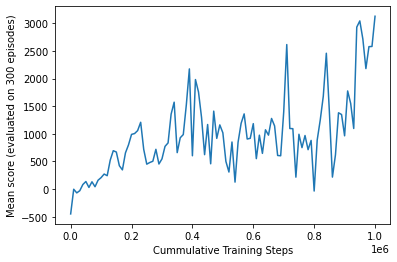

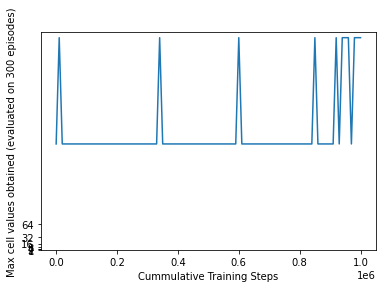

In [ ]:
x_ind = [x*train_steps for x in range(train_epochs+1)]
plt.plot(x_ind, mean_score_evaluations)
plt.ylabel('Mean score (evaluated on {} episodes)'.format(eval_epochs))
plt.xlabel('Cummulative Training Steps')
plt.show()

plt.plot(x_ind, max_values_evaluations)
plt.yticks([pow(2, x) for x in range(7)])
plt.ylabel('Max cell values obtained (evaluated on {} episodes)'.format(eval_epochs))
plt.xlabel('Cummulative Training Steps')
plt.show()

In [ ]:
download_model(save_dir_ppo, save_name_ppo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded!


In [ ]:
name_mean_file = os.path.abspath(os.getcwd())+'/resultPPO_mean_2048_reward'+str(rewardvalue)+'_stepstrain'+str(train_steps)+'_meaneval'+str(eval_epochs)+'.txt'
with open(name_mean_file, 'w') as fopen:
  for el in mean_score_evaluations:
    fopen.write(str(el)+'\n')

name_max_file = os.path.abspath(os.getcwd())+'/resultPPO_max_2048_reward'+str(rewardvalue)+'_stepstrain'+str(train_steps)+'_meaneval'+str(eval_epochs)+'.txt'
with open(name_max_file, 'w') as fopen:
  for el in max_values_evaluations:
    fopen.write(str(el)+'\n')
  
files.download(name_mean_file)
files.download(name_max_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Show best option

In [ ]:
os.environ["SDL_VIDEODRIVER"] = "dummy"
ppo_model_loaded = load_model(save_dir_ppo, save_name_ppo, 'PPO2')

max_value = -1e5
video_frames = []
times = 5
for t in range(times):
  env_show = Game2048Env(4, 4, 6, True)
  observation = env_show.reset()
  for t in range(1001):
    env_show.render('video')
    action, _states = ppo_model_loaded.predict(observation)
    # action = env.action_space.sample()
    observation, reward, done, info = env_show.step(action)

    if done:
      if type(info) == list:
          if info[0]['max_v']>max_value:
            max_value = info[0]['max_v']
            video_frames = env.get_video()
      elif type(info) == dict:
          if info['max_v']>max_value:
            max_value = info['max_v']
            video_frames = env_show.get_video()
      break

Model loaded!


In [ ]:
videodir = os.path.abspath(os.getcwd())+'/videos/'
videoname = 'video2048_ppo.avi'
os.makedirs(videodir, exist_ok=True)


height, width, layers = video_frames[0].shape
size = (width,height)
out = cv2.VideoWriter(videodir+videoname,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(video_frames)):
  for j in range(7):
    out.write(video_frames[i])
out.release()

files.download(videodir+videoname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# DNQ

In [ ]:
save_dir_dqn = "/content/models_saved/"
save_name_dqn = 'best_model2048_dqn'

In [ ]:
# Training + Evaluation every X steps
train_steps = 10000
train_epochs = 50
eval_epochs = 100
print('Training for {} million steps ({} steps * {} epochs)'.format((train_steps*train_epochs)/(1e6), train_steps, train_epochs))

rewardvalue = 4
env = Game2048Env(4, 4, rewardvalue)

kwargs = {'double_q': True, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=False)}

dqn_model = DQN('MlpPolicy', env, verbose=0, gamma=0.95, learning_rate=0.01, batch_size=128, seed=42 , **kwargs)

mean_score_evaluations = []
max_values_evaluations = []
best_mean_results = -9e20

print('Epoch {} -----'.format(0))
mean0, best0, _ = evaluation(dqn_model, env, num_episodes=eval_epochs)
mean_score_evaluations.append(mean0)
max_values_evaluations.append(best0)
print('Mean score = {:.2f}, Max value = {}\n'.format(mean0, best0))
if mean0 > best_mean_results:
  save_model(dqn_model, save_dir_dqn, save_name_dqn)
  best_mean_results = mean0

Training for 0.5 million steps (10000 steps * 50 epochs)







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







Epoch 0 -----


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]

Mean score = -99308.18, Max value = 16

Model saved!


In [ ]:
for i in range(1, train_epochs+1):
  print('Training epoch {} -----'.format(i))
  dqn_model.learn(total_timesteps=train_steps)
  print('Evaluation epoch {} -----'.format(i))
  mean, best, _ = evaluation(dqn_model, env, num_episodes=eval_epochs)
  mean_score_evaluations.append(mean)
  max_values_evaluations.append(best)
  print('Mean score = {:.2f}, Max value = {}\n'.format(mean, best))
  if mean > best_mean_results:
    save_model(dqn_model, save_dir_dqn, save_name_dqn)
    best_mean_results = mean
  print()

Training epoch 1 -----

Evaluation epoch 1 -----


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Mean score = -95124.82, Max value = 64

Model saved!

Training epoch 2 -----
Evaluation epoch 2 -----


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Mean score = -97712.01, Max value = 64


Training epoch 3 -----
Evaluation epoch 3 -----


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Mean score = -98611.39, Max value = 32


Training epoch 4 -----
Evaluation epoch 4 -----


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Mean score = -98704.51, Max value = 32


Training epoch 5 -----
Evaluation epoch 5 -----


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


Mean score = -99046.37, Max value = 32


Training epoch 6 -----
Evaluation epoch 6 -----


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Mean score = -98604.78, Max value = 32


Training epoch 7 -----
Evaluation epoch 7 -----


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Mean score = -98208.01, Max value = 32


Training epoch 8 -----
Evaluation epoch 8 -----


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Mean score = -98324.05, Max value = 64


Training epoch 9 -----
Evaluation epoch 9 -----


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Mean score = -98056.86, Max value = 32


Training epoch 10 -----
Evaluation epoch 10 -----


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Mean score = -98303.61, Max value = 32


Training epoch 11 -----
Evaluation epoch 11 -----


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Mean score = -98383.37, Max value = 32


Training epoch 12 -----
Evaluation epoch 12 -----


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Mean score = -96826.86, Max value = 64


Training epoch 13 -----
Evaluation epoch 13 -----


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Mean score = -98621.88, Max value = 32


Training epoch 14 -----
Evaluation epoch 14 -----


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Mean score = -98110.76, Max value = 32


Training epoch 15 -----
Evaluation epoch 15 -----


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Mean score = -98965.52, Max value = 32


Training epoch 16 -----
Evaluation epoch 16 -----


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Mean score = -98338.40, Max value = 64


Training epoch 17 -----
Evaluation epoch 17 -----


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Mean score = -98595.59, Max value = 32


Training epoch 18 -----
Evaluation epoch 18 -----


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Mean score = -98658.09, Max value = 32


Training epoch 19 -----
Evaluation epoch 19 -----


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Mean score = -98597.33, Max value = 64


Training epoch 20 -----
Evaluation epoch 20 -----


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Mean score = -98899.06, Max value = 32


Training epoch 21 -----
Evaluation epoch 21 -----


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Mean score = -99071.04, Max value = 32


Training epoch 22 -----
Evaluation epoch 22 -----


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Mean score = -99293.35, Max value = 32


Training epoch 23 -----
Evaluation epoch 23 -----


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Mean score = -98756.78, Max value = 32


Training epoch 24 -----
Evaluation epoch 24 -----


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Mean score = -99108.73, Max value = 64


Training epoch 25 -----
Evaluation epoch 25 -----


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Mean score = -99329.25, Max value = 16


Training epoch 26 -----
Evaluation epoch 26 -----


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Mean score = -99333.78, Max value = 16


Training epoch 27 -----
Evaluation epoch 27 -----


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Mean score = -99391.89, Max value = 16


Training epoch 28 -----
Evaluation epoch 28 -----


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Mean score = -99307.51, Max value = 16


Training epoch 29 -----
Evaluation epoch 29 -----


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Mean score = -99186.19, Max value = 16


Training epoch 30 -----
Evaluation epoch 30 -----


100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


Mean score = -99428.47, Max value = 16


Training epoch 31 -----
Evaluation epoch 31 -----


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Mean score = -99427.43, Max value = 16


Training epoch 32 -----
Evaluation epoch 32 -----


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Mean score = -99426.13, Max value = 16


Training epoch 33 -----
Evaluation epoch 33 -----


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Mean score = -99504.20, Max value = 8


Training epoch 34 -----
Evaluation epoch 34 -----


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Mean score = -99486.55, Max value = 16


Training epoch 35 -----
Evaluation epoch 35 -----


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Mean score = -99451.09, Max value = 16


Training epoch 36 -----
Evaluation epoch 36 -----


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Mean score = -99388.26, Max value = 16


Training epoch 37 -----
Evaluation epoch 37 -----


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Mean score = -99450.12, Max value = 16


Training epoch 38 -----
Evaluation epoch 38 -----


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Mean score = -99416.48, Max value = 16


Training epoch 39 -----
Evaluation epoch 39 -----


100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


Mean score = -99337.93, Max value = 16


Training epoch 40 -----
Evaluation epoch 40 -----


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Mean score = -99409.85, Max value = 16


Training epoch 41 -----
Evaluation epoch 41 -----


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Mean score = -99405.18, Max value = 16


Training epoch 42 -----
Evaluation epoch 42 -----


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Mean score = -99436.19, Max value = 16


Training epoch 43 -----
Evaluation epoch 43 -----


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Mean score = -99408.20, Max value = 16


Training epoch 44 -----
Evaluation epoch 44 -----


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Mean score = -99408.52, Max value = 16


Training epoch 45 -----
Evaluation epoch 45 -----


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Mean score = -99458.81, Max value = 16


Training epoch 46 -----
Evaluation epoch 46 -----


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Mean score = -99318.91, Max value = 16


Training epoch 47 -----
Evaluation epoch 47 -----


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Mean score = -99412.96, Max value = 16


Training epoch 48 -----
Evaluation epoch 48 -----


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Mean score = -99412.12, Max value = 16


Training epoch 49 -----
Evaluation epoch 49 -----


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Mean score = -99470.44, Max value = 16


Training epoch 50 -----
Evaluation epoch 50 -----


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]

Mean score = -99444.83, Max value = 16




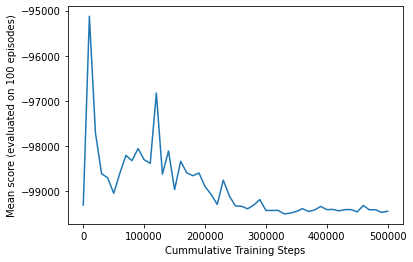

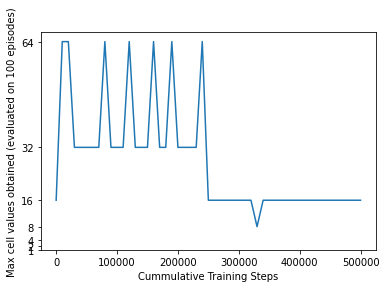

In [ ]:
x_ind = [x*train_steps for x in range(train_epochs+1)]
plt.plot(x_ind, mean_score_evaluations)
plt.ylabel('Mean score (evaluated on {} episodes)'.format(eval_epochs))
plt.xlabel('Cummulative Training Steps')
plt.show()

plt.plot(x_ind, max_values_evaluations)
plt.yticks([pow(2, x) for x in range(7)])
plt.ylabel('Max cell values obtained (evaluated on {} episodes)'.format(eval_epochs))
plt.xlabel('Cummulative Training Steps')
plt.show()

In [ ]:
download_model(save_dir_dqn, save_name_dqn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded!


In [ ]:
os.environ["SDL_VIDEODRIVER"] = "dummy"
name_mean_file = os.path.abspath(os.getcwd())+'/resultDQN_mean_2048_reward'+str(rewardvalue)+'_stepstrain'+str(train_steps)+'_meaneval'+str(eval_epochs)+'.txt'
with open(name_mean_file, 'w') as fopen:
  for el in mean_score_evaluations:
    fopen.write(str(el)+'\n')

name_max_file = os.path.abspath(os.getcwd())+'/resultDQN_max_2048_reward'+str(rewardvalue)+'_stepstrain'+str(train_steps)+'_meaneval'+str(eval_epochs)+'.txt'
with open(name_max_file, 'w') as fopen:
  for el in max_values_evaluations:
    fopen.write(str(el)+'\n')
  
files.download(name_mean_file)
files.download(name_max_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Show best option

In [ ]:
dqn_model_loaded = load_model(save_dir_dqn, save_name_dqn, 'DQN')

max_value = -1e5
video_frames = []
times = 5
for t in range(times):
  env_show = Game2048Env(4, 4, 4, True)
  observation = env_show.reset()
  for t in range(1001):
    env_show.render('video')
    action, _states = dqn_model_loaded.predict(observation)
    # action = env.action_space.sample()
    observation, reward, done, info = env_show.step(action)

    if done:
      if type(info) == list:
          if info[0]['max_v']>max_value:
            max_value = info[0]['max_v']
            video_frames = env.get_video()
      elif type(info) == dict:
          if info['max_v']>max_value:
            max_value = info['max_v']
            video_frames = env_show.get_video()
      break

Model loaded!


In [ ]:
videodir = os.path.abspath(os.getcwd())+'/videos/'
videoname = 'video2048_dqn.avi'
os.makedirs(videodir, exist_ok=True)


height, width, layers = video_frames[0].shape
size = (width,height)
out = cv2.VideoWriter(videodir+videoname,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(video_frames)):
  for j in range(7):
    out.write(video_frames[i])
out.release()

files.download(videodir+videoname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>